<a href="https://colab.research.google.com/github/nahin333/DL-practice-codes/blob/main/transfer_learning_for_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import cv2
import PIL
import PIL.Image as Image
import os
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [46]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
        hub.KerasLayer('https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4', 
                       input_shape= IMAGE_SHAPE + (3, ))
])

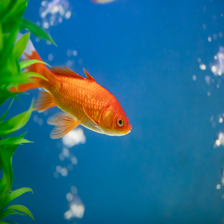

In [47]:
gold_fish = Image.open('goldfish.jpg').resize(IMAGE_SHAPE)
gold_fish

In [48]:
gold_fish = np.array(gold_fish) / 255

In [49]:
gold_fish.shape

(224, 224, 3)

In [50]:
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [51]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

(1, 1001)

In [52]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [53]:
keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

'/root/.keras/datasets/ImageNetLabels.txt'

In [54]:
image_labels = []
with open('/root/.keras/datasets/ImageNetLabels.txt', 'r') as f:
  image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [55]:
image_labels[predicted_label_index]

'goldfish'

In [56]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = keras.utils.get_file('flower_photos', origin=dataset_url, cache_dir='.', untar=True)

In [57]:
data_dir

'./datasets/flower_photos'

In [58]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [59]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/4754734410_94d98463a5.jpg'),
 PosixPath('datasets/flower_photos/roses/2215318403_06eb99176a.jpg'),
 PosixPath('datasets/flower_photos/roses/3624546109_8eb98f0cdb.jpg'),
 PosixPath('datasets/flower_photos/roses/14494590921_3bb1dc7b88_n.jpg'),
 PosixPath('datasets/flower_photos/roses/17158274118_00ec99a23c.jpg')]

In [60]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [61]:
tulips = list(data_dir.glob('tulips/*'))
tulips[:5]

[PosixPath('datasets/flower_photos/tulips/8394186551_28eed83a94_m.jpg'),
 PosixPath('datasets/flower_photos/tulips/15275504998_ca9eb82998.jpg'),
 PosixPath('datasets/flower_photos/tulips/6325571510_7544b27e57_n.jpg'),
 PosixPath('datasets/flower_photos/tulips/13510057763_01b832d919.jpg'),
 PosixPath('datasets/flower_photos/tulips/14015957646_8317a0f1d9_n.jpg')]

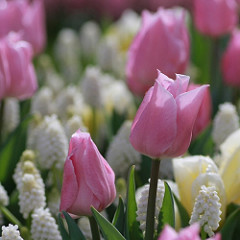

In [62]:
PIL.Image.open(str(tulips[0]))

In [63]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [64]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [65]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))
img.shape

(333, 500, 3)

In [66]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [67]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,IMAGE_SHAPE)
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [68]:
X = np.array(X)
y = np.array(y)

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =0)

In [70]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

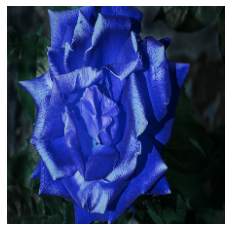

In [71]:
plt.axis('off')
plt.imshow(X[0])

In [72]:
predicted = classifier.predict(np.array([X[0], X[1], X[2]]))
predicted = np.argmax(predicted, axis=1)
predicted

array([795, 795, 795])

In [73]:
image_labels[592]

'handkerchief'

In [74]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [75]:
pretrained_model_without_final_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable =False)

In [76]:
num_of_flower = 5

model = keras.Sequential([
  pretrained_model_without_final_layer,
  keras.layers.Dense(num_of_flower)  
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_4 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
model.compile(
    optimizer = 'adam',
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [78]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 13s 104ms/step - loss: 0.8351 - accuracy: 0.6871
Epoch 2/5
86/86 [==============================] - 9s 104ms/step - loss: 0.4257 - accuracy: 0.8532
Epoch 3/5
86/86 [==============================] - 9s 104ms/step - loss: 0.3321 - accuracy: 0.8892
Epoch 4/5
86/86 [==============================] - 9s 104ms/step - loss: 0.2762 - accuracy: 0.9113
Epoch 5/5
86/86 [==============================] - 9s 104ms/step - loss: 0.2345 - accuracy: 0.9273


In [79]:
model.evaluate(X_test_scaled, y_test)

29/29 [==============================] - 4s 104ms/step - loss: 0.3515 - accuracy: 0.8704


[0.35152286291122437, 0.8703703880310059]

In [80]:
y_predicted = model.predict(X_test_scaled)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_predicted_labels)

Text(69.0, 0.5, 'Truth')

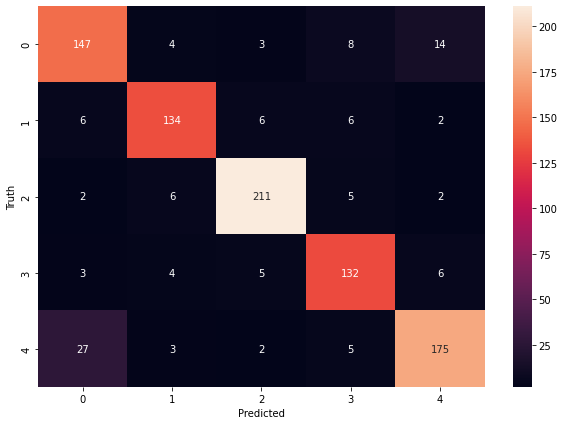

In [81]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [82]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_scaled)
y_pred_classes = [np.argmax(element) for element in y_pred]

print("Classification Report: \n", classification_report(y_test, y_pred_classes))

Classification Report: 
               precision    recall  f1-score   support

           0       0.79      0.84      0.81       176
           1       0.89      0.87      0.88       154
           2       0.93      0.93      0.93       226
           3       0.85      0.88      0.86       150
           4       0.88      0.83      0.85       212

    accuracy                           0.87       918
   macro avg       0.87      0.87      0.87       918
weighted avg       0.87      0.87      0.87       918

